Dataset loading done
Columns: ['date', 'user_id', 'monthly_income', 'monthly_expense_total', 'savings_rate', 'budget_goal', 'financial_scenario', 'credit_score', 'debt_to_income_ratio', 'loan_payment', 'investment_amount', 'subscription_services', 'emergency_fund', 'transaction_count', 'fraud_flag', 'discretionary_spending', 'essential_spending', 'income_type', 'rent_or_mortgage', 'category', 'cash_flow_status', 'financial_advice_score', 'financial_stress_level', 'actual_savings', 'savings_goal_met']

Analyzing user_id = 1153
First few rows of monthly data:
            monthly_expense_total
date                             
2019-01-01                3065.76
2019-02-01                3065.76
2019-03-01                3065.76
2019-04-01                3065.76
2019-05-01                6878.40

Model Evaluation: 
Mean Absolute Error (MAE):  440.92
Mean Squared Error (MSE):   230613.77
Root Mean Squared Error:    480.22


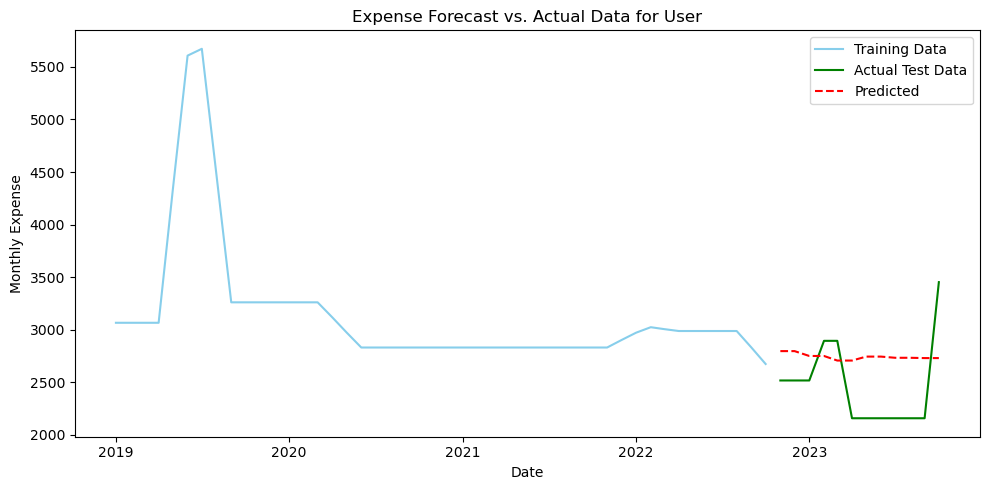

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

file_path = r'C:\Users\Thota Ravindranath\Downloads\personal_finance_tracker_dataset.csv'
df = pd.read_csv(file_path)

print("Dataset loading done")

print("Columns:", df.columns.tolist())

# pre-processing _columns
date_col = 'date'
expense_col = 'monthly_expense_total'

df_subset = df[[date_col, expense_col, 'user_id']].copy()
df_subset[date_col] = pd.to_datetime(df_subset[date_col])  #formattingDaet

top_user = df_subset['user_id'].value_counts().idxmax()
df_user = df_subset[df_subset['user_id'] == top_user].copy()
df_user.set_index(date_col, inplace=True)

# modify nulls & add monthly expe
df_monthly = df_user[[expense_col]].resample('MS').sum().sort_index()
df_monthly = df_monthly.replace(0, np.nan).ffill()

print(f"\nAnalyzing user_id = {top_user}")
print("First few rows of monthly data:")
print(df_monthly.head())

# train&test
split_point = int(len(df_monthly) * 0.8)
train_data = df_monthly.iloc[:split_point]
test_data = df_monthly.iloc[split_point:]

# ARIMA model
model = ARIMA(train_data[expense_col], order=(5, 1, 0))
model_fit = model.fit()

# Predict
forecast_res = model_fit.get_forecast(steps=len(test_data))
predictions = forecast_res.predicted_mean

# actual & predicted values
results = pd.concat([
    test_data[expense_col].rename('Actual'),
    predictions.rename('Predicted')
], axis=1).dropna()

# performance
mae = mean_absolute_error(results['Actual'], results['Predicted'])
mse = mean_squared_error(results['Actual'], results['Predicted'])
rmse = np.sqrt(mse)

print("\nModel Evaluation: ")
print(f"Mean Absolute Error (MAE):  {mae:.2f}")
print(f"Mean Squared Error (MSE):   {mse:.2f}")
print(f"Root Mean Squared Error:    {rmse:.2f}")

# visualization
plt.figure(figsize=(10,5))
plt.plot(train_data[expense_col].rolling(3, min_periods=1).mean(), label='Training Data', color='skyblue')
plt.plot(test_data[expense_col], label='Actual Test Data', color='green')
plt.plot(results['Predicted'], label='Predicted', color='red', linestyle='--')
plt.title(f'Expense Forecast vs. Actual Data for User')
plt.xlabel('Date')
plt.ylabel('Monthly Expense')
plt.legend()
plt.tight_layout()
plt.show()